In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
clinical = pd.read_csv("./data/COADREAD.clin.merged.picked.txt", sep = "\t").T
clinical.columns = clinical.iloc[0,:]
clinical = clinical.drop("Hybridization REF").drop(columns = ["Composite Element REF"])
clinical.index = list(map(str.upper, clinical.index))

stage_info = clinical[["pathologic_stage", "number_of_lymph_nodes", "years_to_birth", "date_of_initial_pathologic_diagnosis"]]
stage_info = stage_info.dropna(subset = "pathologic_stage")
stage_info["stage"] = [i.rstrip("a").rstrip("b").rstrip("c") for i in stage_info.iloc[:,0]]
stage_info["patient"] = stage_info.index
roman_dict = {"stage i" : 1, "stage ii" : 2, "stage iii" : 3, "stage iv" : 4}
stage_info["stage_num"] = [roman_dict[i] for i in stage_info["stage"]]
stage_info.head()

Hybridization REF,pathologic_stage,number_of_lymph_nodes,years_to_birth,date_of_initial_pathologic_diagnosis,stage,patient,stage_num
TCGA-A6-2677,stage iiic,5,68,2009,stage iii,TCGA-A6-2677,3
TCGA-A6-2681,stage iia,0,73,2009,stage ii,TCGA-A6-2681,2
TCGA-A6-2682,stage iv,2,70,2009,stage iv,TCGA-A6-2682,4
TCGA-A6-4105,stage iia,0,79,2010,stage ii,TCGA-A6-4105,2
TCGA-A6-6649,stage iiib,2,66,2010,stage iii,TCGA-A6-6649,3


In [3]:
crc_msi = pd.read_csv("./data/crc_msi.csv")
crc_msi.loc[crc_msi["msi"] == "msi-l", "msi"] = "mss"
stage_info = stage_info.merge(crc_msi, left_on = "patient", right_on = "bcr_patient_barcode")
stage_info["date_of_initial_pathologic_diagnosis"] = stage_info["date_of_initial_pathologic_diagnosis"].astype("Int64")
stage_info["number_of_lymph_nodes"] = stage_info["number_of_lymph_nodes"].astype("Int64")
stage_info["years_to_birth"] = stage_info["years_to_birth"].astype("Int64")

In [4]:
stage_info["stage"].value_counts()

stage ii     226
stage iii    181
stage i      109
stage iv      90
Name: stage, dtype: int64

<AxesSubplot:xlabel='msi', ylabel='years_to_birth'>

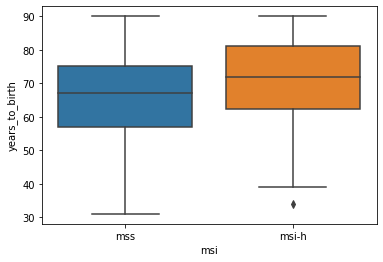

In [6]:
sns.boxplot(data = stage_info, x = "msi", y = "years_to_birth")

<AxesSubplot:xlabel='stage', ylabel='years_to_birth'>

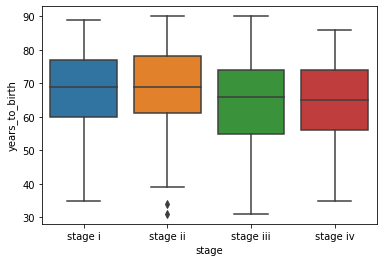

In [7]:
sns.boxplot(data = stage_info, x = "stage", y = "years_to_birth", order = ["stage i", "stage ii", "stage iii", "stage iv"])

#### STR mutation length

In [9]:
str_diff = pd.read_csv("./data/20230525_autosomal_mutations_only.csv")
str_diff = str_diff.merge(stage_info, on = "patient")

In [10]:
str_diff["stage"].value_counts()

stage ii     35160
stage iii    17639
stage i      15572
stage iv     12445
Name: stage, dtype: int64

In [11]:
msi_data = str_diff.loc[str_diff.msi == "msi-h"]
mss_data = str_diff.loc[str_diff.msi == "mss"]
msi_data["patient"].nunique(), mss_data["patient"].nunique()

(24, 117)

In [13]:
x = msi_data["stage_num"]
y = msi_data["patient_len_diff"]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       patient_len_diff   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     600.7
Date:                Tue, 27 Jun 2023   Prob (F-statistic):          2.20e-131
Time:                        18:11:12   Log-Likelihood:                -78407.
No. Observations:               30704   AIC:                         1.568e+05
Df Residuals:                   30702   BIC:                         1.568e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3581      0.061     38.839      0.000       2.239       2.477
stage_num      0.7130      0.029     24.509      0.000       0.656       0.770
==============================================================================
Omnibus:                    14519.970   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            96527.428
Skew:                           2.194   Prob(JB):                         0.00
Kurtosis:                      10.497   Cond. No.                         8.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
model.pvalues

const         0.000000e+00
stage_num    2.195539e-131
dtype: float64

In [15]:
x_mss = mss_data["stage_num"]
y_mss = mss_data["patient_len_diff"]
x_mss = sm.add_constant(x_mss)
model_mss = sm.OLS(y_mss, x_mss).fit()
model_mss.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       patient_len_diff   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     34.24
Date:                Tue, 27 Jun 2023   Prob (F-statistic):           4.90e-09
Time:                        18:11:35   Log-Likelihood:            -1.0476e+05
No. Observations:               50112   AIC:                         2.095e+05
Df Residuals:                   50110   BIC:                         2.095e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0774      0.023     91.909      0.000       2.033       2.122
stage_num      0.0480      0.008      5.852      0.000       0.032       0.064
==============================================================================
Omnibus:                    36305.379   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           803918.392
Skew:                           3.278   Prob(JB):                         0.00
Kurtosis:                      21.494   Cond. No.                         7.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
model_mss.pvalues

const        0.000000e+00
stage_num    4.896238e-09
dtype: float64

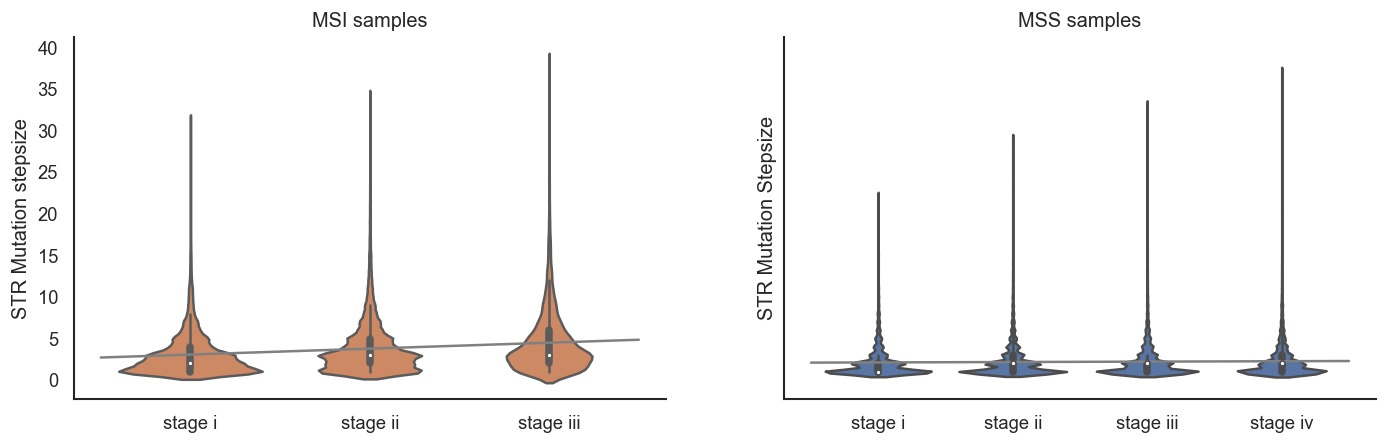

In [17]:
x_line = np.array([0.5,1,2,3.5])
y_line = x_line*model.params[1] + model.params[0]
sns.set_theme(style="white")
fig, axs = plt.subplots(1, 2, figsize=(14, 4), dpi = 120, sharey = True)
sns.violinplot(ax = axs[0], data = msi_data, x = "stage_num", y = "patient_len_diff", color = sns.color_palette()[1], order = [1, 2, 3, 4])
axs[0].set_xticklabels(["stage i", "stage ii", "stage iii", "stage iv"])
axs[0].set(ylabel = "STR Mutation stepsize", xlabel = "")
axs[0].set_title("MSI samples")
axs[0].plot(x_line-1, y_line, color = "grey")
sns.despine()

x_mss = np.array([0.5,1,2,3, 4, 4.5])
y_mss = x_mss*model_mss.params[1] + model_mss.params[0]
sns.violinplot(ax = axs[1], data = mss_data, x = "stage_num", y = "patient_len_diff", color = sns.color_palette()[0])
axs[1].set_xticklabels(["stage i", "stage ii", "stage iii", "stage iv"])
axs[1].set_title("MSS samples")
axs[1].set(ylabel = "STR Mutation Stepsize", xlabel = "")
axs[1].plot(x_mss-1, y_mss, color = "grey")